In [206]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from collections import Counter

In [207]:
# 1. Charger les données
with open('post_process/processed_reviews_combined.json', 'r') as f:
    documents = json.load(f)

In [208]:
# 2. Convertir les listes de tokens en strings pour TfidfVectorizer
documents_str = [' '.join(doc) for doc in documents]

Exemple de valeurs dans documents_str :
```json
[
  [
    "plantronic",
    "headset",
    "husband",
    "headset",
    "choice",
    "time",
    "purchase",
    "year",
    "work",
    "cell",
    "iphone",
    "remember",
    "number",
    "headset",
    "come"
  ]
]
```
Nous avons 1000 avis, et chaque avis est représenté par une liste de tokens. On a donc 1000 listes de tokens, et on va les convertir en 1000 strings pour pouvoir les passer à TfidfVectorizer.

In [209]:
# 3. Créer et appliquer TF-IDF
tfidf = TfidfVectorizer(min_df=20, max_df=0.95)
tfidf_matrix = tfidf.fit_transform(documents_str)

On notera qu'ici, nous avons déjà utilisé les paramètres optimaux pour de meilleurs résultats. Ces paramètres ont été déterminés dans un autre notebook, et sont les suivants :
- `min_df=20` : On ignore les mots qui apparaissent dans moins de 20 documents. Cela permet de réduire le bruit dans les données.
- `max_df=0.95` : On ignore les mots qui apparaissent dans plus de 95% des documents. Cela permet de réduire les mots très fréquents qui ne sont pas très informatifs.

In [210]:
# 4. Méthode du coude
inertias = []
K = range(1, 11)  # Tester de 1 à 10 clusters

In [211]:
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    inertias.append(kmeans.inertia_)

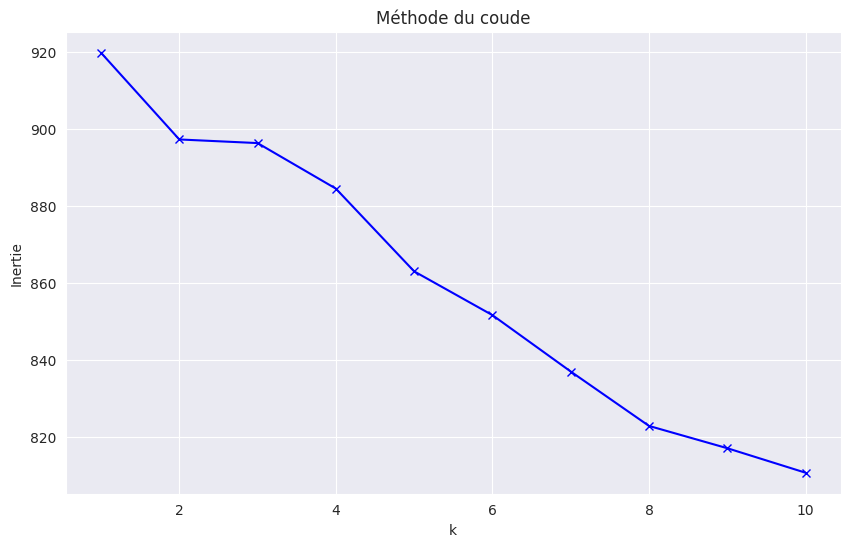

In [212]:
# Visualiser la courbe du coude
plt.figure(figsize=(10, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertie')
plt.title('Méthode du coude')
plt.show()

On peut observer que la courbe du coude commence à s'aplatir à partir de k=2, ou vers k=8. Cela signifie que le nombre optimal de clusters est probablement une de ces deux valeurs. Cependant, la courbe ne montre pas réellement de "coud" très net, donc il peut y avoir une certaine subjectivité dans le choix du nombre optimal de clusters. On va donc, à la place, essayer de choisir un nombre de clusters basé sur le score de silhouette.

In [213]:
from sklearn.metrics import silhouette_score

In [214]:
# Calculer les scores de silhouette pour différentes valeurs de k
silhouette_scores = []
K = range(2, 11)  # On commence à 2 car le score de silhouette n'est pas défini pour k=1

In [215]:
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(tfidf_matrix)
    silhouette_avg = silhouette_score(tfidf_matrix, cluster_labels)
    silhouette_scores.append(silhouette_avg)

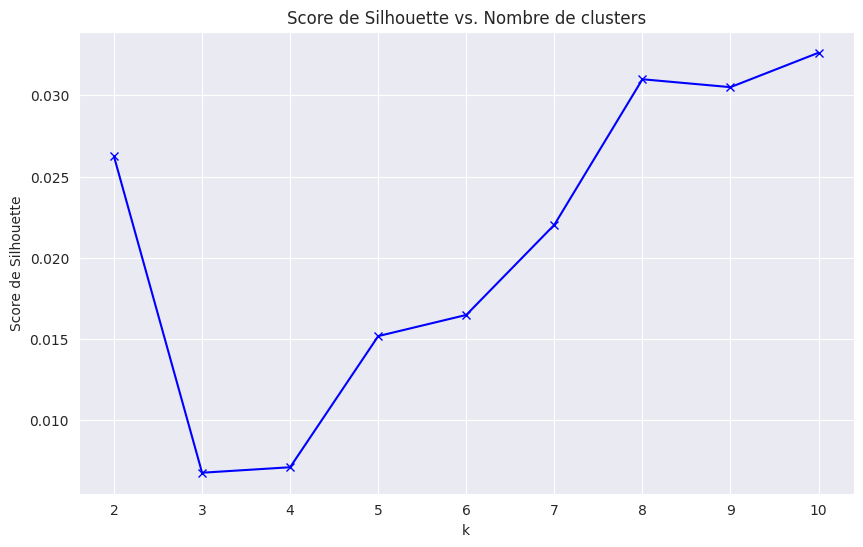

In [216]:
# Visualiser les scores de silhouette
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Score de Silhouette')
plt.title('Score de Silhouette vs. Nombre de clusters')
plt.show()

Le score de silhouette n'aide pas plus à déterminer le nombre de clusters à choisir.
- Premièrement, il est très faible (entre 0.01 et 0.03) pour toutes les valeurs de k testées.
- Deuxièmement, le maximum semble être atteint pour k=8, malgré un léger pic à k=2, ce qui suit la tendance observée avec la méthode du coude.

Comme le score de silhouette semble s'étendre au-delà de 10 clusters, on va essayer de pousser en calculant le score de silhouette pour k=2 à k=20. Nous avions commencé par regarder les résultats pour un petit nombre de clusters, comme ceux-ci sont plus faciles à visualiser mais également à interpréter. Cependant, il est possible que le score de silhouette soit plus élevé pour un nombre de clusters plus élevé.


In [226]:
# Calculer les scores de silhouette pour différentes valeurs de k
silhouette_scores = []
K = range(2, 20)

In [227]:
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(tfidf_matrix)
    silhouette_avg = silhouette_score(tfidf_matrix, cluster_labels)
    silhouette_scores.append(silhouette_avg)

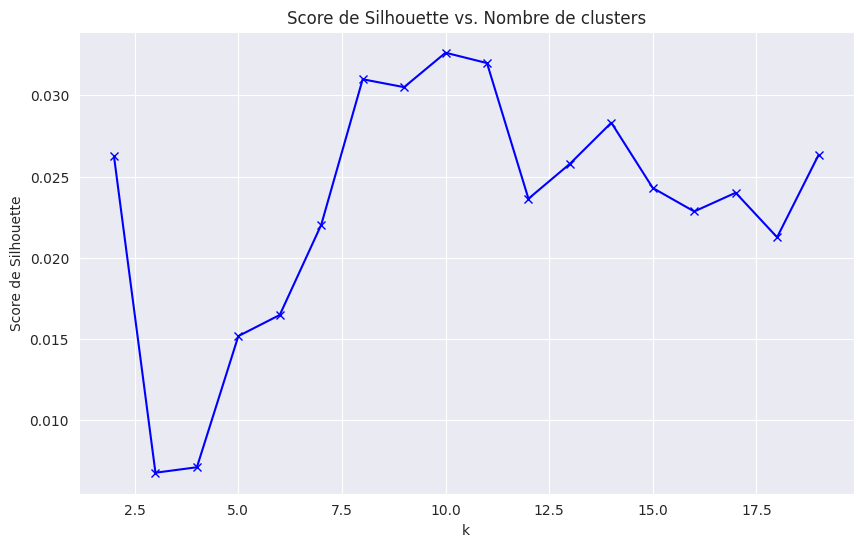

In [228]:
# Visualiser les scores de silhouette
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Score de Silhouette')
plt.title('Score de Silhouette vs. Nombre de clusters')
plt.show()

Cette courbe est assez inhabituelle !
- La plage de valeurs est toujours très faible (entre 0.01 et 0.03), ce qui indique que les clusters ne sont pas très bien séparés, quel que soit le nombre de clusters choisi;
- Il y a beaucoup d'oscillations et d'instabilité dans la courbe, ce qui n'est pas typique pour un score de silhouette. Normalement, on s'attendrait à une courbe plus lisse;
- Le pic à k=10 semble être un maximum local, mais la différence avec les autres valeurs est minime...

Ces observations peuvent suggérer que les données sont peut-être trop bruitées, ou que la représentation TF-IDF n'est pas la plus adaptée pour notre jeu de données. Il faut également garder en tête que le jeu de données est assez petit (seulement 1000 avis), ce qui peut rendre l'analyse plus difficile.

Mais avant d'abandonner l'utiliser de TfidfVectorizer, on va quand même essayer de visualiser les clusters pour k=2 et k=8 pour voir si cela nous aide à choisir.

In [240]:
def analyze_clusters(k, tfidf_matrix, tfidf, documents):
    # Appliquer KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(tfidf_matrix)
    
    # Analyser chaque cluster
    cluster_sizes = []
    print(f"\nAnalyse pour k={k} clusters:")
    
    for i in range(k):
        # Trouver les documents dans ce cluster
        cluster_docs = [doc for doc, cluster in zip(documents, clusters) if cluster == i]
        cluster_sizes.append(len(cluster_docs))
        
        # Compter les mots les plus fréquents dans ce cluster
        all_words = [word for doc in cluster_docs for word in doc]
        word_freq = Counter(all_words)
        
        print(f"\nCluster {i}:")
        print(f"Nombre de documents: {len(cluster_docs)}")
        print("Top 10 mots les plus fréquents:")
        for word, freq in word_freq.most_common(10):
            print(f"{word}: {freq}")
            
    # Visualiser la distribution des tailles des clusters
    plt.figure(figsize=(10, 6))
    plt.bar(range(k), cluster_sizes)
    plt.xlabel('Numéro du cluster')
    plt.ylabel('Nombre de documents')
    plt.title(f'Distribution des documents dans les {k} clusters')
    plt.show()

In [251]:
def show_cluster_examples(k, tfidf_matrix, documents, n_examples=3):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(tfidf_matrix)
    
    print(f"\nExemples de documents pour k={k}:")
    for i in range(k):
        print(f"\nCluster {i}:")
        # Trouver les indices des documents dans ce cluster
        cluster_indices = [j for j, label in enumerate(clusters) if label == i]
        # Sélectionner aléatoirement n_examples indices
        sample_indices = np.random.choice(cluster_indices, min(n_examples, len(cluster_indices)), replace=False)
        # Afficher les documents correspondants
        for idx, doc_idx in enumerate(sample_indices):
            # sous forme de phrase
            print(f"Exemple {idx+1}: {' '.join(documents[doc_idx])}")


Analyse pour k=2 clusters:

Cluster 0:
Nombre de documents: 733
Top 10 mots les plus fréquents:
phone: 727
case: 698
great: 284
good: 244
fit: 240
love: 210
screen: 183
like: 178
look: 160
nice: 146

Cluster 1:
Nombre de documents: 267
Top 10 mots les plus fréquents:
work: 281
charge: 206
great: 163
phone: 128
charger: 125
use: 89
review: 89
time: 87
cable: 78
like: 76


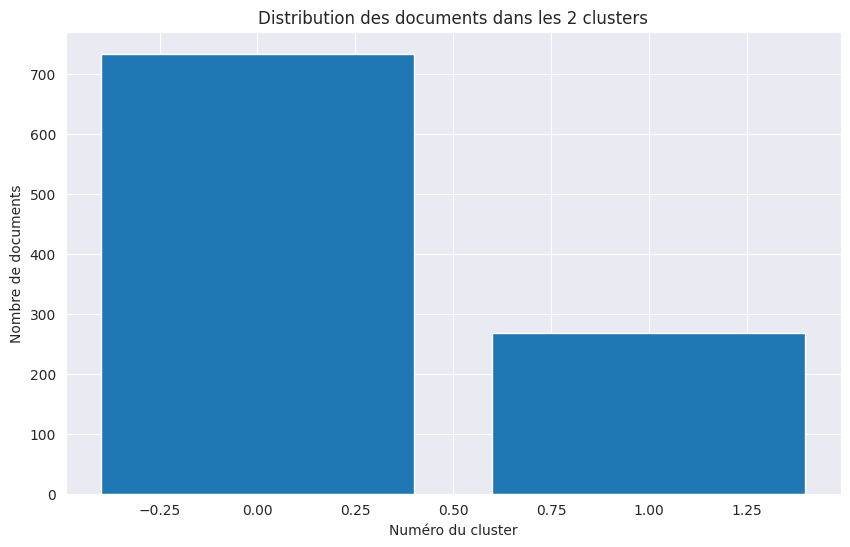

In [252]:
# Analyser pour k=2
analyze_clusters(2, tfidf_matrix, tfidf, documents)

In [253]:
show_cluster_examples(2, tfidf_matrix, documents)


Exemples de documents pour k=2:

Cluster 0:
Exemple 1: stick sticky removable fit phone case leave sticky residue want leave good purchase
Exemple 2: star great light
Exemple 3: big picture left large like reflective metal face plastic soft good protecting

Cluster 1:
Exemple 1: great bargain price great stylus tip work pen feature well expect include bonus stylus nice surprise skinny stay loop kindle fire case think loop gotten stretch time definitely purchase need
Exemple 2: toy iphone obviously phone work shell pretend purchase grandson ask know work weighty glass metal realistic purchase clear silicone cover glass front choose gold gray color screen instead black realistic glance hold boy year old thrill play time comfort know actually work entertaining probably year lucky hesitate update review new info useful
Exemple 3: magnetic love magnetic wire useful swivel head cord need useful attach fix angle need swivel head


Comme on pouvait s'y attendre, les clusters ne sont pas très distincts. Les mots les plus fréquents dans chaque cluster sont assez similaires, et les tailles des clusters sont également assez proches. Cependant, nous pouvons tout de même distinguer des différences de thématiques entre les clusters. Le premier mentionne "phone", et "case" là où le second a l'air d'être plus "penché" sur les chargeurs !


Analyse pour k=8 clusters:

Cluster 0:
Nombre de documents: 429
Top 10 mots les plus fréquents:
phone: 264
screen: 141
like: 132
good: 124
fit: 122
love: 108
work: 104
great: 98
easy: 92
look: 80

Cluster 1:
Nombre de documents: 120
Top 10 mots les plus fréquents:
charge: 192
charger: 116
phone: 86
work: 84
cable: 68
time: 52
need: 47
good: 45
long: 44
usb: 44

Cluster 2:
Nombre de documents: 55
Top 10 mots les plus fréquents:
nice: 79
phone: 27
case: 20
look: 18
fit: 13
love: 11
like: 10
work: 10
use: 8
good: 8

Cluster 3:
Nombre de documents: 208
Top 10 mots les plus fréquents:
case: 579
phone: 416
great: 109
good: 93
fit: 90
love: 79
protect: 66
cover: 66
protection: 57
like: 54

Cluster 4:
Nombre de documents: 45
Top 10 mots les plus fréquents:
star: 52
phone: 13
great: 9
case: 8
love: 6
feel: 6
product: 6
nice: 6
color: 5
fit: 5

Cluster 5:
Nombre de documents: 5
Top 10 mots les plus fréquents:
edge: 15
case: 13
phone: 12
gold: 5
brown: 4
screen: 4
elago: 4
scratch: 4
leave: 4
fl

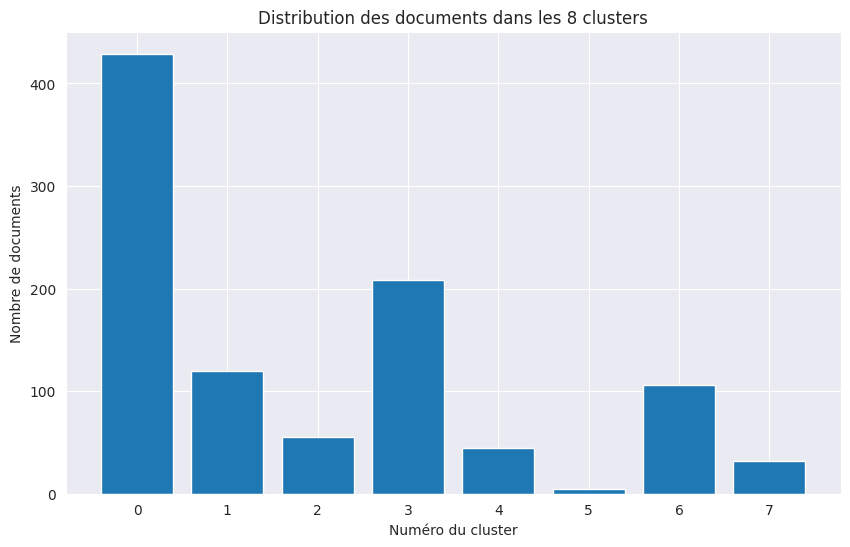

In [247]:
# Analyser pour k=8
analyze_clusters(8, tfidf_matrix, tfidf, documents)

In [245]:
show_cluster_examples(8, tfidf_matrix, documents)


Exemples de documents pour k=8:

Cluster 0:
Document 1: excellent protection thing impress ease installation screen protector multiple air bubble leave instal clarity screen protector touch sensitivity excellent look forward resist fingerprint...
Document 2: absolutely beautiful beautiful piece...
Document 3: thin protect thin non protective worth price return...

Cluster 1:
Document 1: charger samsung phone ear bud watch need charger unbelievably handy working place wireless plug reduce cord clutter charge fast honestly godsend purchase bed stand travel addicted place charge love far...
Document 2: outlet usb power strip good look need outlet port usb charge port great addition room purchase guest room perfect size shape long wide electrical outlet usb port cover pop usb...
Document 3: happy product charger need size usb versus usb type need great...

Cluster 2:
Document 1: work protector case protect good protector crack screen careful look nice describe...
Document 2: nice charger 

Cette fois, les résultats sont plus intéressants. Les clusters sont bien plus distincts, mais certains sont moins significatifs que d'autres.
- Le cluster 0 se concentre sur l'expérience utilisateur générale des appareils, d'ailleurs de façon assez positif ! on y retrouve les mots clés "phone", "screen", "like", "good", ...
- Le cluster 1, comme pour le k=2, est plus concentré sur l'utilisation du chargeur: "charge", "cable", ...
- Le cluster 3 concerne les avis sur les protections ("case") avec des mots positifs encore ("great", "good", "fit") mais dans les derniers mots clés, on retrouve aussi "cover", "protection"... ce qui confirme que la thématique !

Les autres clusters, plus petits que ceux cités au-dessus (avec entre 5 et 55 documents contre 106 à 429 pour les 3 gros clusters), sont plus difficiles à interpréter. Cela peut être dû à la nature bruitée des données, ou à la difficulté de trouver des thèmes clairs dans des avis de consommateurs.


Après une utilisation plus ou moins fructueuse de KMeans, il peut être intéressant d'essayer une approche avec DBScan. Cette méthode est plus adaptée pour des clusters de formes arbitraires, et peut être plus robuste face au bruit. Cependant, elle est plus sensible aux hyperparamètres, et peut être plus difficile à interpréter. On va donc essayer d'appliquer DBScan sur nos données pour voir si cela donne de meilleurs résultats.

In [254]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np

In [255]:
# Convertir la matrice sparse en matrice dense et normaliser
tfidf_dense = tfidf_matrix.toarray()
scaler = StandardScaler(with_mean=False)
tfidf_scaled = scaler.fit_transform(tfidf_dense)

In [256]:
# Fonction pour analyser les résultats de DBSCAN
def analyze_dbscan_clusters(labels, documents):
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    print(f"Nombre de clusters trouvés: {n_clusters}")
    print(f"Nombre de points considérés comme bruit: {n_noise}")
    
    # Analyser chaque cluster
    for i in range(-1, max(labels) + 1):  # -1 est pour les points de bruit
        cluster_docs = [doc for doc, cluster in zip(documents, labels) if cluster == i]
        
        if i == -1:
            print("\nPoints de bruit:")
        else:
            print(f"\nCluster {i}:")
            
        print(f"Nombre de documents: {len(cluster_docs)}")
        
        if len(cluster_docs) > 0:
            # Compter les mots les plus fréquents
            all_words = [word for doc in cluster_docs for word in doc]
            word_freq = Counter(all_words)
            print("Top 10 mots les plus fréquents:")
            for word, freq in word_freq.most_common(10):
                print(f"{word}: {freq}")

In [259]:
# Essayer différentes valeurs de eps
eps_values = [0.1, 0.3, 0.5, 0.7, 1.0]
min_samples_values = [2, 3, 5, 10]

In [260]:
for eps in eps_values:
    for min_samples in min_samples_values:
        print(f"\n=== DBSCAN avec eps={eps}, min_samples={min_samples} ===")
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(tfidf_scaled)
        analyze_dbscan_clusters(labels, documents)


=== DBSCAN avec eps=0.1, min_samples=2 ===
Nombre de clusters trouvés: 9
Nombre de points considérés comme bruit: 975

Points de bruit:
Nombre de documents: 975
Top 10 mots les plus fréquents:
phone: 855
case: 727
great: 437
work: 344
good: 312
fit: 260
like: 254
love: 251
charge: 227
screen: 204

Cluster 0:
Nombre de documents: 4
Top 10 mots les plus fréquents:
star: 4
crap: 1
garbage: 1
dollar: 1
store: 1
strictly: 1
fantastic: 1

Cluster 1:
Nombre de documents: 2
Top 10 mots les plus fréquents:
case: 2
love: 2
sparkle: 1
yes: 1

Cluster 2:
Nombre de documents: 2
Top 10 mots les plus fréquents:
star: 2
love: 2
compartment: 1

Cluster 3:
Nombre de documents: 3
Top 10 mots les plus fréquents:
great: 3
versatility: 2
satisfied: 1
customer: 1
handy: 1
emergency: 1

Cluster 4:
Nombre de documents: 4
Top 10 mots les plus fréquents:
junk: 2
stylus: 1
pen: 1
bring: 1
mistake: 1
wrong: 1
convenient: 1
reliable: 1
ask: 1

Cluster 5:
Nombre de documents: 2
Top 10 mots les plus fréquents:
look:

Les résultats de DBScan ne sont pas très concluants non plus. Les clusters trouvés sont très petits, et la plupart des points sont considérés comme du bruit. Cela peut être dû à la densité relativement faible des données, ou à la difficulté de trouver des clusters significatifs dans des avis de consommateurs.